In [ ]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(9)

In [ ]:
!unzip '/content/test_images.zip'

Archive:  /content/test_images.zip
   creating: test_images/
  inflating: test_images/scraped_2_0_0_image.jpg  
  inflating: test_images/scraped_2_0_1_image.jpg  
  inflating: test_images/scraped_2_0_2_image.jpg  
  inflating: test_images/scraped_2_0_3_image.jpg  
  inflating: test_images/scraped_2_0_4_image.jpg  
  inflating: test_images/scraped_2_0_5_image.jpg  
  inflating: test_images/scraped_2_0_6_image.jpg  
  inflating: test_images/scraped_2_0_7_image.jpg  
  inflating: test_images/scraped_2_0_8_image.jpg  
  inflating: test_images/scraped_2_0_9_image.jpg  
  inflating: test_images/scraped_2_10000_0_image.jpg  
  inflating: test_images/scraped_2_10000_1_image.jpg  
  inflating: test_images/scraped_2_10000_2_image.jpg  
  inflating: test_images/scraped_2_10000_3_image.jpg  
  inflating: test_images/scraped_2_10000_4_image.jpg  
  inflating: test_images/scraped_2_10000_5_image.jpg  
  inflating: test_images/scraped_2_10009_0_image.jpg  
  inflating: test_images/scraped_2_10009_10_

In [ ]:
!mkdir test
!mv '/content/bathroom' '/content/test'
!mv '/content/bedroom' '/content/test'
!mv '/content/frontal' '/content/test'
!mv '/content/kitchen' '/content/test'

In [ ]:
!mkdir '/content/test_images/1'
!mkdir '/content/test_images/2'
!mkdir '/content/test_images/3'
!mkdir '/content/test_images/4'
!mkdir '/content/test_images/5'
!mkdir '/content/test_images/6'

In [ ]:
!ls -a test_images
!rm -R '/content/test_images/.ipynb_checkpoints/'
!ls -a test_images

.  ..  1  2  3	4  5  6  .ipynb_checkpoints
.  ..  1  2  3	4  5  6


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('/content/test_images', transform=transform)

#train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])

batch_size = 32
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
#val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

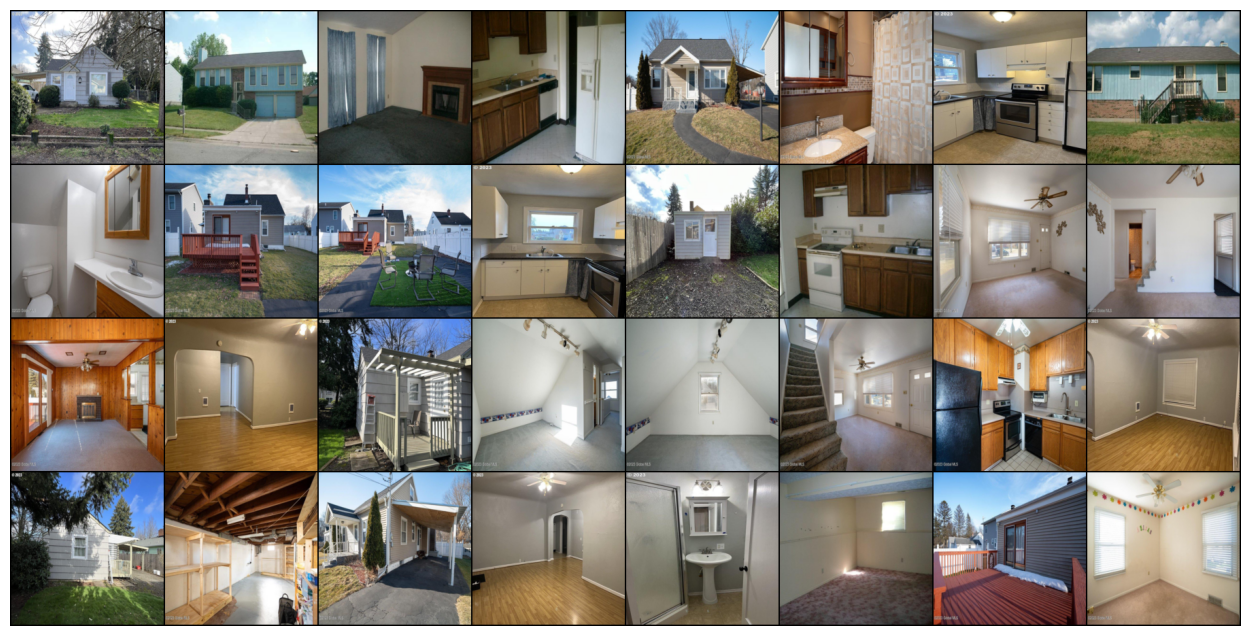

In [ ]:
from torchvision.utils import make_grid

for images, _ in test_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [ ]:
class Inception(nn.Module):

    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=6):
        super(Inception, self).__init__()

        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)

        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None

        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)

        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)

        x = self.linear(x)

        return x, y, z

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()

        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)

        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)

        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)

    def forward(self, x):
        x1 = self.one_by_one(x)

        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)

        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)

        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [ ]:
class Auxiliary(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = Inception()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model.to(device)
next(model.parameters()).is_cuda

True

In [ ]:
epochs = 20 #50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, use_auxiliary=True):

    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data

                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train

                    if phase == 'train': # Backward + optimize only if in training phase
                        if use_auxiliary:
                            outputs, aux1, aux2 = model(inputs)
                            loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                        else:
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()

                    if phase == 'val':
                        outputs, _, _ = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)

Epoch 1/20
----------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x780166820f70>
<function _MultiProcessingDataLoaderIter.__del__ at 0x780166820f70>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

train Loss: 5.0767 Acc: 0.5461
val Loss: 3.4673 Acc: 0.4642

Epoch 2/20
----------


KeyboardInterrupt: ignored

In [ ]:
PATH = './Kaggle_CNN.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
net = Inception()
PATH = '/content/New_Kaggle_CNN.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
outputs

(tensor([[ 0.3155,  0.7923,  6.6037,  ..., -4.5843, -4.4083, -4.5495],
         [ 5.9817,  4.6568, -1.2656,  ..., -3.8440, -3.7758, -3.9872],
         [-1.5041, -2.5103,  9.5881,  ..., -4.3361, -3.8357, -4.3773],
         ...,
         [ 1.0590, -0.8822,  8.3037,  ..., -4.2829, -4.2817, -4.1873],
         [ 6.5391,  2.1036,  1.5981,  ..., -4.5156, -4.8545, -4.7759],
         [ 2.4589, -0.6885,  9.2291,  ..., -4.4476, -4.7155, -4.8585]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 1.0223,  2.8646, 11.6281,  ..., -3.5205, -3.2524, -3.2085],
         [11.6855,  5.2083,  1.3463,  ..., -2.8708, -2.9741, -3.1875],
         [ 3.5169, -0.3734, 15.2711,  ..., -2.8040, -2.6260, -2.9068],
         ...,
         [ 5.2677,  3.6166, 17.3643,  ..., -4.0184, -3.8693, -3.6927],
         [ 6.8946,  3.3258,  3.9520,  ..., -2.5938, -2.9328, -2.7381],
         [ 5.0767,  1.6957, 13.8653,  ..., -3.0269, -3.2179, -2.7607]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 2.7914,  3.3732, 11.8123,  ..., -2.63

In [ ]:
loss = criterion(outputs, torch.max(labels,1)[0])

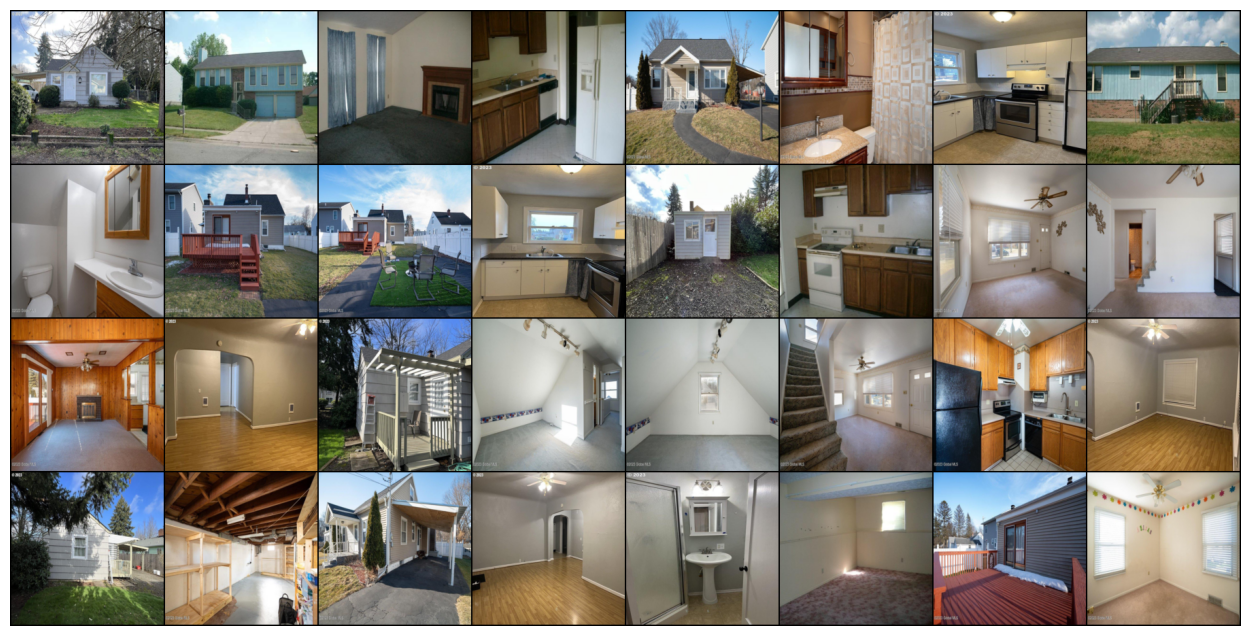

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
for images, _ in test_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [ ]:
for i in outputs:
  _, predicted = torch.max(i, 1)

classes = ('dining_room', 'bedroom', 'bathroom', 'living_room', 'kitchen', 'frontal')

print('Predicted: ', ' '.join(f'{j+1}-{classes[predicted[j]]:5s}'
                              for j in range(32)))

Predicted:  1-frontal 2-kitchen 3-frontal 4-bedroom 5-kitchen 6-frontal 7-kitchen 8-bathroom 9-bedroom 10-frontal 11-frontal 12-bedroom 13-kitchen 14-bedroom 15-bedroom 16-bedroom 17-kitchen 18-frontal 19-bedroom 20-bedroom 21-bedroom 22-kitchen 23-bedroom 24-kitchen 25-frontal 26-kitchen 27-kitchen 28-bathroom 29-kitchen 30-bedroom 31-frontal 32-bedroom


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        for i in outputs:
          _, predicted = torch.max(i.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the many test images: 87 %
